# Problem Statement

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

Content The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

# Loading the Packages

In [1]:
# IMPORTING PACKAGES

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from termcolor import colored as cl 
import itertools 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier 

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, jaccard_score, roc_curve, roc_auc_score

# Data Wrangling

## Gather the Data

**About the data:** The data we are going to use is the Kaggle Credit Card Fraud Detection dataset (click here for the dataset). It contains features V1 to V28 which are the principal components obtained by PCA. We are going to neglect the time feature which is of no use to build the models. The remaining features are the ‘Amount’ feature that contains the total amount of money being transacted and the ‘Class’ feature that contains whether the transaction is a fraud case or not.

In [2]:
# IMPORTING DATA

df = pd.read_csv('creditcard.csv')
df.drop('Time', axis = 1, inplace = True)

print(df.head())

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0  0.098698  0.363787  0.090794  ... -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425 -0.166974  ... -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  0.207643  ...  0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024 -0.054952  ... -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  0.753074  ... -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount  Class  
0  0.1285

# Preprocessing and EDA

Let's look at the distribution of fraud and non-fraud cases in our sample. Let's also calculate the proportion of fraud incidents in the total number of recorded transactions.

In [3]:
cases = len(df)
nonfraud_count = len(df[df.Class == 0])
fraud_count = len(df[df.Class == 1])
fraud_percentage = round(fraud_count/nonfraud_count*100, 2)

print(cl('CASE COUNT', attrs = ['bold']))
print(cl('--------------------------------------------', attrs = ['bold']))
print(cl('Total number of cases are {}'.format(cases), attrs = ['bold']))
print(cl('Number of Non-fraud cases are {}'.format(nonfraud_count), attrs = ['bold']))
print(cl('Number of Non-fraud cases are {}'.format(fraud_count), attrs = ['bold']))
print(cl('Percentage of fraud cases is {}'.format(fraud_percentage), attrs = ['bold']))
print(cl('--------------------------------------------', attrs = ['bold']))

CASE COUNT
--------------------------------------------
Total number of cases are 284807
Number of Non-fraud cases are 284315
Number of Non-fraud cases are 492
Percentage of fraud cases is 0.17
--------------------------------------------


We can see that out of 284,807 samples, there are only 492 fraud cases which is only 0.17 percent of the total samples. So, we can say that the data we are dealing with is highly imbalanced data and needs to be handled carefully when modeling and evaluating.

In [4]:
nonfraud_cases = df[df.Class == 0]
fraud_cases = df[df.Class == 1]

print(cl('CASE AMOUNT STATISTICS', attrs = ['bold']))
print(cl('--------------------------------------------', attrs = ['bold']))
print(cl('NON-FRAUD CASE AMOUNT STATS', attrs = ['bold']))
print(nonfraud_cases.Amount.describe())
print(cl('--------------------------------------------', attrs = ['bold']))
print(cl('FRAUD CASE AMOUNT STATS', attrs = ['bold']))
print(fraud_cases.Amount.describe())
print(cl('--------------------------------------------', attrs = ['bold']))

CASE AMOUNT STATISTICS
--------------------------------------------
NON-FRAUD CASE AMOUNT STATS
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64
--------------------------------------------
FRAUD CASE AMOUNT STATS
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64
--------------------------------------------


While seeing the statistics, it is seen that the values in the ‘Amount’ variable are varying enormously when compared to the rest of the variables. To reduce its wide range of values, we can normalize it using the ‘StandardScaler’ method in python.

In [5]:
scaler = StandardScaler()
amount = df['Amount'].values

df['Amount'] = scaler.fit_transform(amount.reshape(-1, 1))

print(cl(df['Amount'].head(10), attrs = ['bold']))

0    0.244964
1   -0.342475
2    1.160686
3    0.140534
4   -0.073403
5   -0.338556
6   -0.333279
7   -0.190107
8    0.019392
9   -0.338516
Name: Amount, dtype: float64


# Modelling

In [6]:
# Declare the feature and target
X = df.drop('Class', axis=1).values
y = df['Class'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
# Define the classifiers
classifiers = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier()}

Classifier: KNN
F1 score: 0.8571
Jaccard index: 0.7500
Accuracy score: 0.9995
Confusion matrix:
[[56854     7]
 [   20    81]]



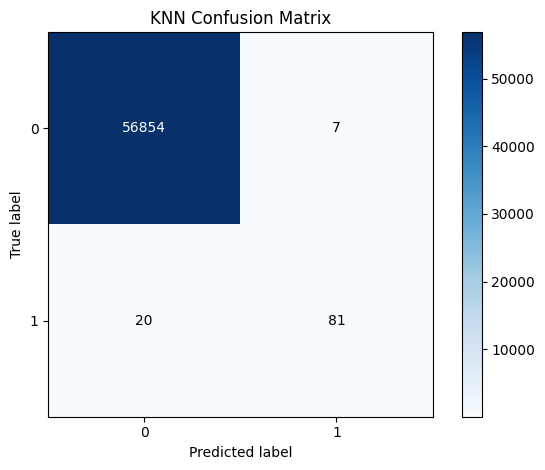

Classifier: Decision Tree
F1 score: 0.7647
Jaccard index: 0.6190
Accuracy score: 0.9992
Confusion matrix:
[[56836    25]
 [   23    78]]



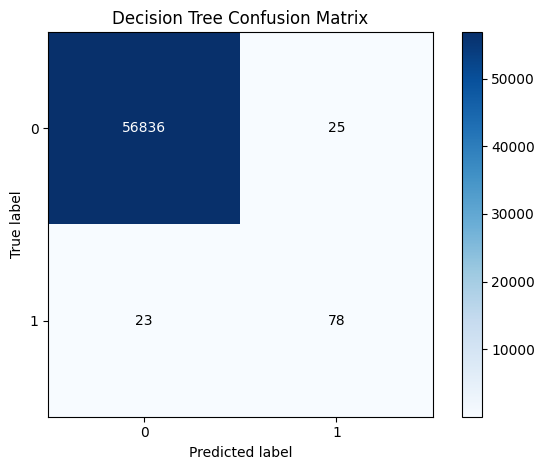

Classifier: Naive Bayes
F1 score: 0.1223
Jaccard index: 0.0652
Accuracy score: 0.9783
Confusion matrix:
[[55642  1219]
 [   15    86]]



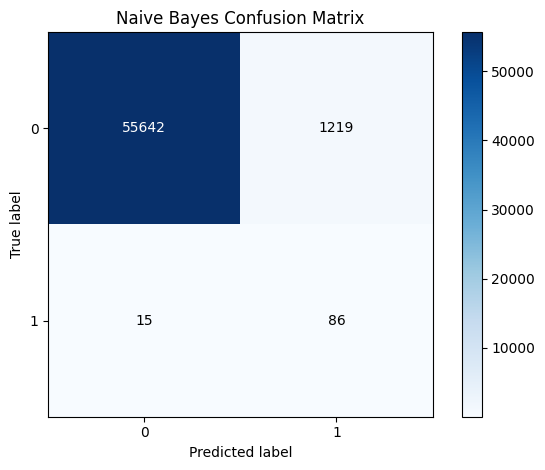

Classifier: SVM
F1 score: 0.7771
Jaccard index: 0.6355
Accuracy score: 0.9993
Confusion matrix:
[[56855     6]
 [   33    68]]



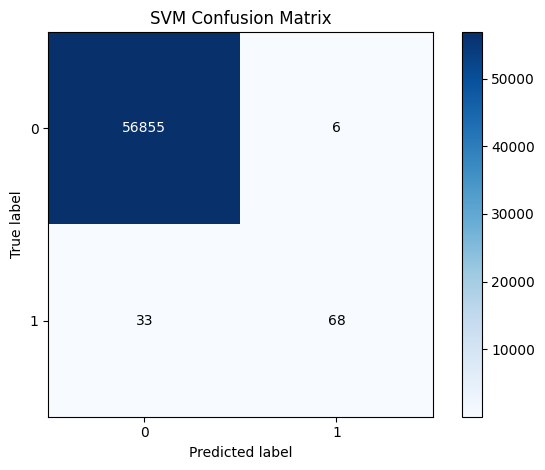

Classifier: Logistic Regression
F1 score: 0.7356
Jaccard index: 0.5818
Accuracy score: 0.9992
Confusion matrix:
[[56852     9]
 [   37    64]]



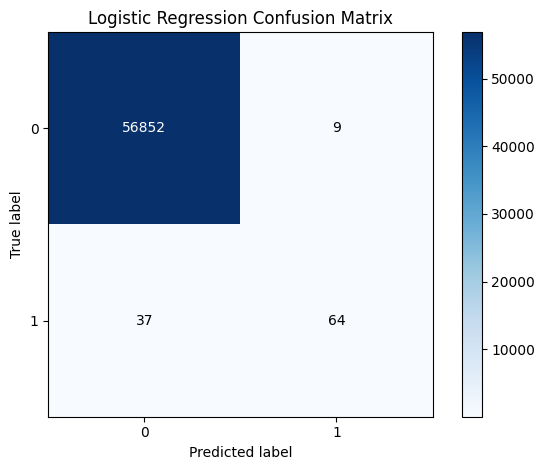

Classifier: Random Forest
F1 score: 0.8511
Jaccard index: 0.7407
Accuracy score: 0.9995
Confusion matrix:
[[56854     7]
 [   21    80]]



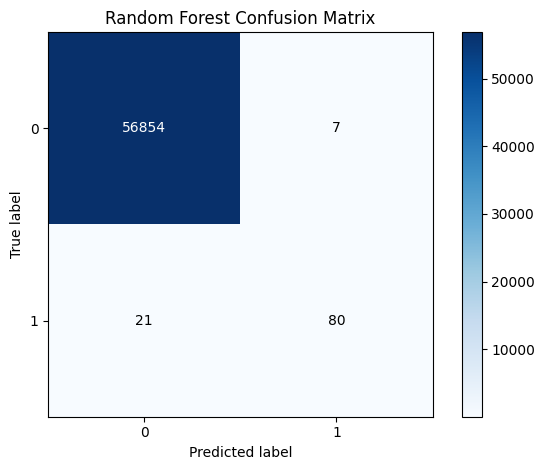

Classifier: Gradient Boosting
F1 score: 0.7514
Jaccard index: 0.6018
Accuracy score: 0.9992
Confusion matrix:
[[56849    12]
 [   33    68]]



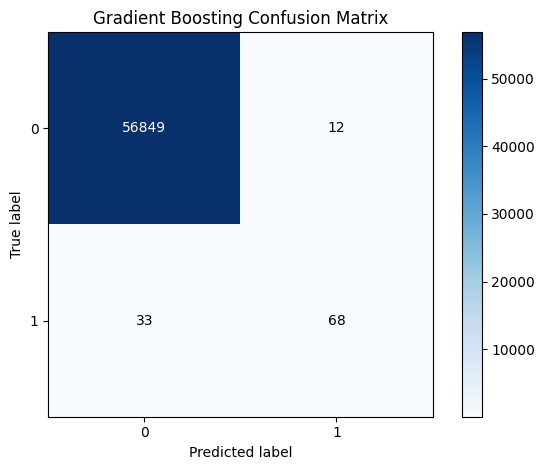

Classifier: XGBoost
F1 score: 0.8691
Jaccard index: 0.7685
Accuracy score: 0.9996
Confusion matrix:
[[56854     7]
 [   18    83]]



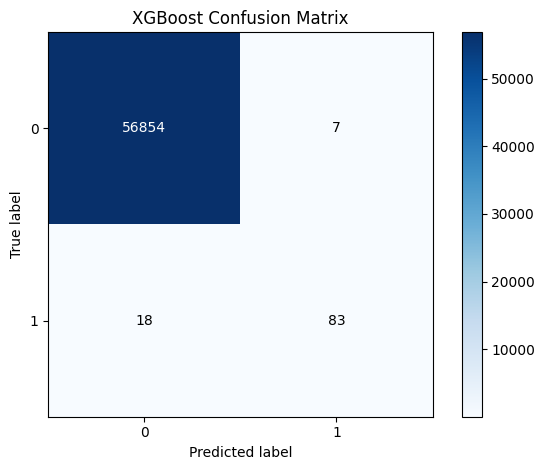

In [8]:
# Loop through the classifiers and compute their evaluation metrics
for name, clf in classifiers.items():
    # Fit the classifier on the training data
    clf.fit(X_train, y_train)
        
    # Make predictions on the test data
    y_pred = clf.predict(X_test)
        
    # Compute the evaluation metrics
    f1 = f1_score(y_test, y_pred)
    jaccard = jaccard_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
        
    # Print the evaluation metrics
    print(f'Classifier: {name}')
    print(f'F1 score: {f1:.4f}')
    print(f'Jaccard index: {jaccard:.4f}')
    print(f'Accuracy score: {accuracy:.4f}')
    print(f'Confusion matrix:\n{cm}\n')
        
    # Plot the confusion matrix
    plt.figure()
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title(f'{name} Confusion Matrix')
    plt.colorbar()
    classes = np.unique(y)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

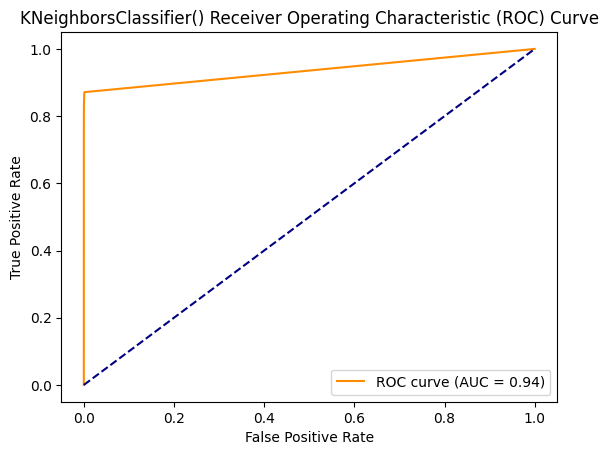

In [9]:
# Make predictions on the test data
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred_prob = clf.predict_proba(X_test)[:, 1]
    
# Compute the false positive rate (fpr), true positive rate (tpr), and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
# Compute the Area Under the Curve (AUC) for the ROC curve
auc = roc_auc_score(y_test, y_pred_prob)
    
# Plot the ROC curve
        
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{clf} Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

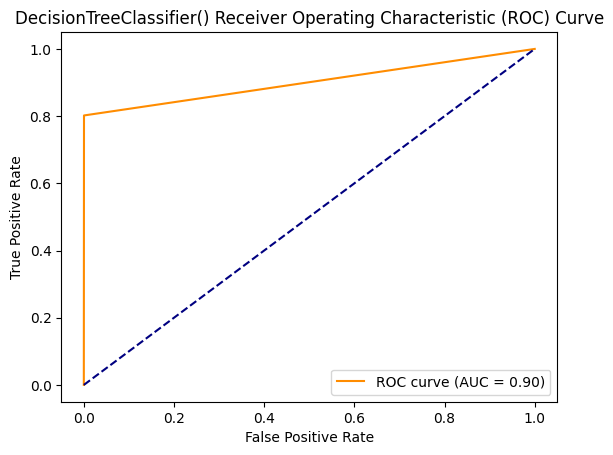

In [10]:
# Make predictions on the test data
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred_prob = clf.predict_proba(X_test)[:, 1]
    
# Compute the false positive rate (fpr), true positive rate (tpr), and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
# Compute the Area Under the Curve (AUC) for the ROC curve
auc = roc_auc_score(y_test, y_pred_prob)
    
# Plot the ROC curve
        
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{clf} Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

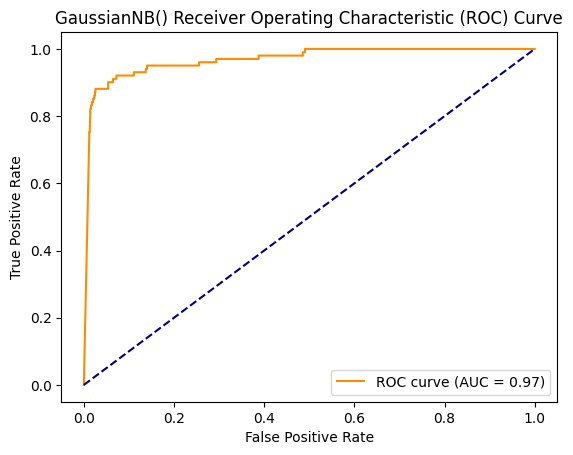

In [11]:
# Make predictions on the test data
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred_prob = clf.predict_proba(X_test)[:, 1]
    
# Compute the false positive rate (fpr), true positive rate (tpr), and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
# Compute the Area Under the Curve (AUC) for the ROC curve
auc = roc_auc_score(y_test, y_pred_prob)
    
# Plot the ROC curve
        
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{clf} Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# # Make predictions on the test data
# clf = SVC(probability=True)
# clf.fit(X_train, y_train)
# y_pred_prob = clf.predict_proba(X_test)[:, 1]
    
# # Compute the false positive rate (fpr), true positive rate (tpr), and thresholds for the ROC curve
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
# # Compute the Area Under the Curve (AUC) for the ROC curve
# auc = roc_auc_score(y_test, y_pred_prob)
    
# # Plot the ROC curve
        
# plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title(f'{clf} Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()

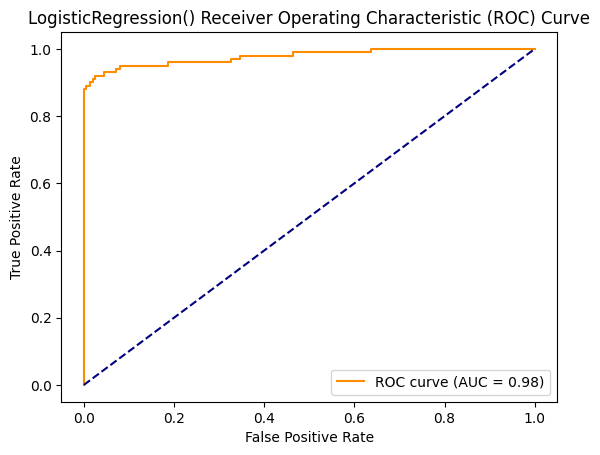

In [12]:
# Make predictions on the test data
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred_prob = clf.predict_proba(X_test)[:, 1]
    
# Compute the false positive rate (fpr), true positive rate (tpr), and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
# Compute the Area Under the Curve (AUC) for the ROC curve
auc = roc_auc_score(y_test, y_pred_prob)
    
# Plot the ROC curve
        
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{clf} Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

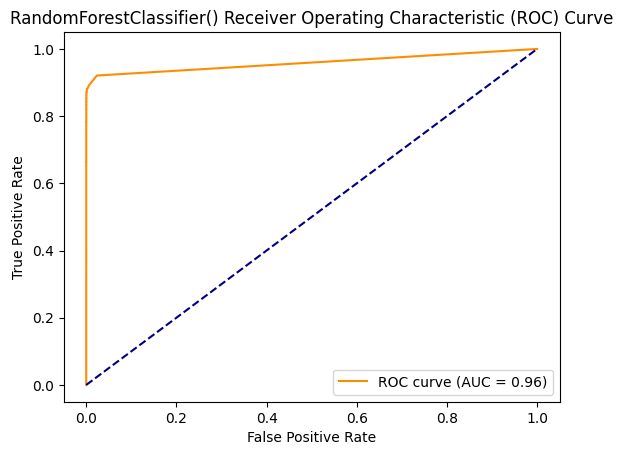

In [13]:
# Make predictions on the test data
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred_prob = clf.predict_proba(X_test)[:, 1]
    
# Compute the false positive rate (fpr), true positive rate (tpr), and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
# Compute the Area Under the Curve (AUC) for the ROC curve
auc = roc_auc_score(y_test, y_pred_prob)
    
# Plot the ROC curve
        
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{clf} Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

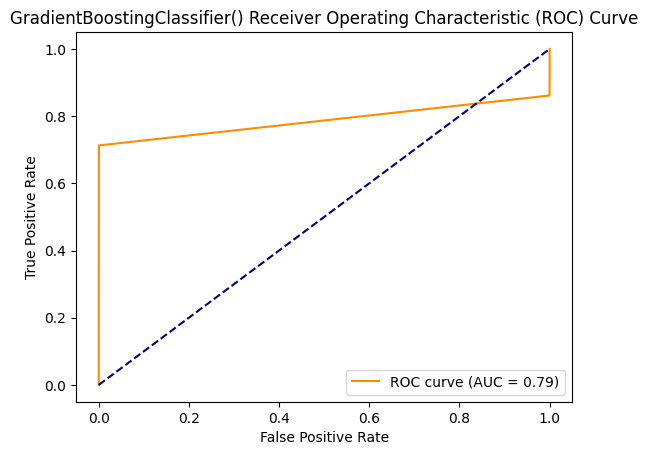

In [14]:
# Make predictions on the test data
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred_prob = clf.predict_proba(X_test)[:, 1]
    
# Compute the false positive rate (fpr), true positive rate (tpr), and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
# Compute the Area Under the Curve (AUC) for the ROC curve
auc = roc_auc_score(y_test, y_pred_prob)
    
# Plot the ROC curve
        
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{clf} Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

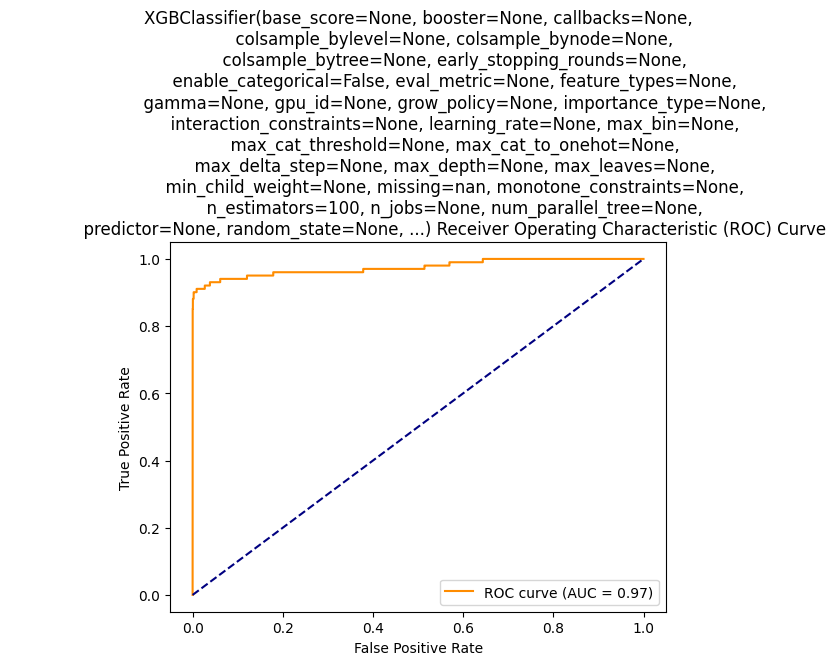

In [15]:
# Make predictions on the test data
clf = XGBClassifier()
clf.fit(X_train, y_train)
y_pred_prob = clf.predict_proba(X_test)[:, 1]
    
# Compute the false positive rate (fpr), true positive rate (tpr), and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
# Compute the Area Under the Curve (AUC) for the ROC curve
auc = roc_auc_score(y_test, y_pred_prob)
    
# Plot the ROC curve
        
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{clf} Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
dir()